In [2]:
import sys
import numpy as np
import pandas as pd
import py_noise as pn
import os
import matplotlib.pyplot as plt
plt.close('all')

In [3]:
f = r'C:\Users\WH6\OneDrive - Van Oord\sound\sammy_kriegers_flak\Kriegers Flak Piling Sequence Scenarios.xlsx'

In [4]:
D = pd.read_excel(f,sheet_name='Base case', nrows=5000)
D.columns

Index([           'Blow Number',      'Blow Time (ratio)',
                  'Blow energy',               'Time (s)',
             'Blow Energy (kJ)',            'SEL Source ',
                      'SEL max', 'Distance travelled (m)',
              'SEL at distance',     'SEL (ratio of max)',
             'Propagation loss',                 'SELcum',
                     'SEL @750',                  'SEL05',
                  'Unnamed: 14',            'Unnamed: 15',
                  'Unnamed: 16',            'Unnamed: 17',
                  'Unnamed: 18',            'Unnamed: 19',
                  'Unnamed: 20',            'Unnamed: 21',
                  'Unnamed: 22',            'Unnamed: 23',
                       'Blows ',                      500],
      dtype='object')

In [5]:
DD =  D[['Blow Number', 'Time (s)','Blow Energy (kJ)','SEL Source ']]
print (DD[0:5])
DD[len(D)-2:len(D)-1]

   Blow Number  Time (s)  Blow Energy (kJ)  SEL Source 
0            1  1.518768             402.0     210.6996
1            2  3.037536             402.0     212.6996
2            3  4.556304             402.0     212.6996
3            4  6.075072             402.0     212.6996
4            5  7.593840             402.0     212.6996


,Blow Number,Time (s),Blow Energy (kJ),SEL Source
4998,4999,7592.321232,1846.194538,219.631734


In [9]:
t_soft_start = list(range(10,2001,50))   # length soft start in minutes
hammer_freq = 1/3      # blows per second
E_soft = 250          # soft 
SEL_soft = 150
test_case = pd.DataFrame()
test_case = DD
stat_soft_start = pd.DataFrame(index = t_soft_start, columns = ['t_new [min]', 't_del [min]','t_tot [hrs]','blow_new','blow_del','blow_tot',
                                          'E_new [10^3 kJ]', 'E_del [10^3 kJ]','E_tot [10^3 kJ]', 'SEL_cum [dB]', 'SEL_05 [dB]'])

check_cases = []
for case in t_soft_start:
    temp_case = pd.DataFrame(columns = DD.columns)
    
    soft_length = case*60
    blow_no = soft_length*hammer_freq
    
    stat_soft_start.loc[case,'t_new [min]'] = case
    stat_soft_start.loc[case,'blow_new'] = blow_no
    stat_soft_start.loc[case,'E_new [10^3 kJ]'] = blow_no*E_soft/1000
    
    temp_case['Blow Number'] = np.arange(blow_no)+1
    temp_case['Time (s)'] = np.arange(0, soft_length, 1/hammer_freq)
    temp_case['Blow Energy (kJ)'] = np.repeat(E_soft, blow_no)
    temp_case['SEL Source '] = np.repeat(SEL_soft, blow_no)
        

    energy_start = sum(temp_case['Blow Energy (kJ)'])
    
    tcxx = test_case.copy()
    val = pd.Index(tcxx['Blow Energy (kJ)'].cumsum()).get_loc(energy_start, 'nearest')
    
    stat_soft_start.loc[case,'blow_del'] = tcxx['Blow Number'][tcxx.index == val].values[0]
    stat_soft_start.loc[case,'t_del [min]'] = tcxx['Time (s)'][tcxx.index == val].values[0]/60
    stat_soft_start.loc[case,'E_del [10^3 kJ]'] = tcxx['Blow Energy (kJ)'][0:val+1].sum()/1000
    

    tcx = tcxx.iloc[val+1:len(tcxx)]
    tcx['Time (s)'] = tcx['Time (s)'] +temp_case.loc[len(temp_case)-1, 'Time (s)'] - tcxx.loc[val,'Time (s)']
    tcx['Blow Number'] = tcx['Blow Number'] + temp_case['Blow Number'][len(temp_case)-1] - tcxx['Blow Number'][tcxx.index == val].values
    
    print (temp_case['Blow Number'][len(temp_case)-1])
    scenario = temp_case.append(tcx, ignore_index=True, sort = False)
    stat_soft_start.loc[case,'t_tot [hrs]'] = scenario['Time (s)'][len(scenario)-1]/60/60
    stat_soft_start.loc[case,'blow_tot'] = scenario['Blow Number'][len(scenario)-1]
    stat_soft_start.loc[case,'E_tot [10^3 kJ]'] = scenario['Blow Energy (kJ)'].sum()/1000
    
    stat_soft_start.loc[case,'SEL_cum [dB]'] = pn.SELcum(scenario['Time (s)'], scenario['SEL Source '], rhyd=1)[0]
    stat_soft_start.loc[case,'SEL_05 [dB]'] = pn.SELpercentile(scenario['SEL Source '])
    
    check_cases.append(scenario)

    tcx.drop(tcx.index, inplace=True)
    tcxx.drop(tcxx.index, inplace=True)
    scenario.drop(tcxx.index, inplace=True)
    temp_case.drop(tcxx.index, inplace=True)
    
print (stat_soft_start)
    
    
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anac

200.0
1200.0
2200.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

3200.0
4200.0
5200.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

6200.0
7200.0
8200.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

9200.0
10200.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anac

11200.0
12200.0
13200.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

14200.0
15200.0
16200.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

17200.0
18200.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

19200.0
20200.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

21200.0
22200.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

23200.0
24200.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

25200.0
26200.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

27200.0
28200.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anac

29200.0
30200.0
31200.0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anac

32200.0
33200.0
34200.0
35200.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A 

36200.0
37200.0
38200.0
39200.0
     t_new [min] t_del [min] t_tot [hrs] blow_new blow_del blow_tot  \
10            10     3.13879     2.22292      200      124     5076   
60            60      14.403     2.86852     1200      569     5631   
110          110     21.8196     3.57824     2200      862     6338   
160          160     27.8694     4.31074     3200     1101     7099   
210          210     33.1598      5.0559     4200     1310     7890   
260          260     37.9692     5.80908     5200     1500     8700   
310          310     42.4496     6.56774     6200     1677     9523   
360          360     46.6515     7.33104     7200     1843    10357   
410          410     50.6509     8.09772     8200     2001    11199   
460          460     54.4731     8.86735     9200     2152    12048   
510          510     58.1688     9.63909    10200     2298    12902   
560          560     61.7632     10.4125    11200     2440    13760   
610          610     65.2564     11.1876    1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


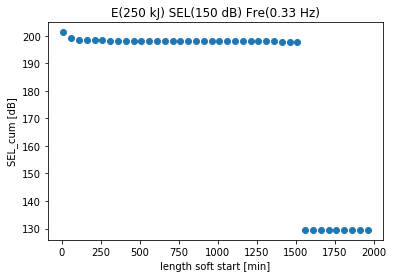

In [10]:
plt.figure()
plt.scatter(stat_soft_start['t_new [min]'], stat_soft_start['SEL_cum [dB]'])
plt.xlabel('length soft start [min]')
plt.ylabel('SEL_cum [dB]')
plt.title('E('+ str(E_soft) + ' kJ)'+ ' SEL('+ str(SEL_soft) + ' dB)'+ ' Fre('+ str(round(hammer_freq,2)) +' Hz)')
plt.savefig('E('+ str(E_soft) + ' kJ)'+ ' SEL('+ str(SEL_soft) + ' dB)')
plt.show()

In [11]:
stat_soft_start

,t_new [min],t_del [min],t_tot [hrs],blow_new,blow_del,blow_tot,E_new [10^3 kJ],E_del [10^3 kJ],E_tot [10^3 kJ],SEL_cum [dB],SEL_05 [dB]
10,10,3.13879,2.22292,200,124,5076,50,49.848,7790.28,201.297,220.439
60,60,14.403,2.86852,1200,569,5631,300,299.887,7790.24,199.226,220.437
110,110,21.8196,3.57824,2200,862,6338,550,550.331,7789.8,198.67,220.434
160,160,27.8694,4.31074,3200,1101,7099,800,800.29,7789.84,198.462,220.43
210,210,33.1598,5.0559,4200,1310,7890,1050,1049.71,7790.42,198.371,220.426
260,260,37.9692,5.80908,5200,1500,8700,1300,1299.46,7790.67,198.329,220.421
310,310,42.4496,6.56774,6200,1677,9523,1550,1550.34,7789.79,198.307,220.415
360,360,46.6515,7.33104,7200,1843,10357,1800,1800.37,7789.76,198.296,220.409
410,410,50.6509,8.09772,8200,2001,11199,2050,2050.57,7789.57,198.29,220.403
460,460,54.4731,8.86735,9200,2152,12048,2300,2299.92,7790.21,198.287,220.396


In [124]:
print (len(check_cases))
print (check_cases[10][2190:2210])

20
      Blow Number     Time (s)  Blow Energy (kJ)  SEL Source 
2190       2191.0  6570.000000        300.000000   200.000000
2191       2192.0  6573.000000        300.000000   200.000000
2192       2193.0  6576.000000        300.000000   200.000000
2193       2194.0  6579.000000        300.000000   200.000000
2194       2195.0  6582.000000        300.000000   200.000000
2195       2196.0  6585.000000        300.000000   200.000000
2196       2197.0  6588.000000        300.000000   200.000000
2197       2198.0  6591.000000        300.000000   200.000000
2198       2199.0  6594.000000        300.000000   200.000000
2199       2200.0  6597.000000        300.000000   200.000000
2200       2201.0  6598.518768       1040.251223   215.763206
2201       2202.0  6600.037536       1040.938403   215.766504
2202       2203.0  6601.556304       1041.625341   215.769802
2203       2204.0  6603.075072       1042.312037   215.773098
2204       2205.0  6604.593840       1042.998491   215.776393
2205 

In [55]:
test = pd.DataFrame(columns = ['a','b','c','d'])
test['a'] = [2,2,2,2]
test['b'] = [4,4,4,4]
test['c'] = [1,1,1,1]
test['d'] = [5,5,5,5]

print (test[0:len(test)])
print (sum(test['a'][0:3]))
print (len(test))

test.xs(0)['a'] = test['b'][2]/2
print (test)
test.loc[0,'a'] = test['b'][2]/2
test['d'] = np.repeat(1,4)
test['a'] = test['a'].add(1)
print (test)

   a  b  c  d
0  2  4  1  5
1  2  4  1  5
2  2  4  1  5
3  2  4  1  5
6
4
   a  b  c  d
0  2  4  1  5
1  2  4  1  5
2  2  4  1  5
3  2  4  1  5
     a  b  c  d
0  3.0  4  1  1
1  3.0  4  1  1
2  3.0  4  1  1
3  3.0  4  1  1


In [17]:
print (60*60*24 - 77780.844)
print (60*60*24 - 76412.844)

8619.156000000003
9987.156000000003
